# Recommendation System Project: IBM Community

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>


### Imports and Load Data

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t


df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)
# Show df to get an idea of the data
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` Are there any missing values? If so, provide a count of missing values. If there are missing values in `email`, assign it the same id value `"unknown_user"`.

In [74]:
# Some interactions do not have a user associated with it, assume the same user.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [75]:
# Count the number of Null values in the email column
email_null_count = df['email'].isnull().sum()
print(f"Number of Null email values is: {email_null_count}")

Number of Null email values is: 17


In [76]:
# Fill email NaNs with "unknown_user"
df['email'] = df['email'].fillna('unknown_user')

In [77]:
# Check if no more NaNs 
df[df.email.isna()]

,Unnamed: 0,article_id,title,email


`2.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [78]:
# What are the descriptive statistics of the number of articles a user interacts with?

# Calcate unique values of columns to get an overview of the dataset
print(f'There are {len(df['article_id'].unique())} unique articles ids in the dataset.')
print(f'There are {len(df['title'].unique())} unique titles in the dataset.')
print(f'There are {len(df['email'].unique())} unique emails in the dataset.')

There are 714 unique articles ids in the dataset.
There are 714 unique titles in the dataset.
There are 5149 unique emails in the dataset.


In [79]:
# Calculate a user by article matrix
user_by_article = df.groupby(['email', 'article_id'])['article_id'].count().unstack()

user_by_article.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
email,,,,,,,,,,,,,,,,,,,,,
0000b6387a0366322d7fbfc6434af145adf7fed1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
001055fc0bb67f71e8fa17002342b256a30254cd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00148e4911c7e04eeff8def7bbbdaf1c59c2c621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
001a852ecbd6cc12ab77a785efa137b2646505fe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
001fc95b90da5c3cb12c501d201a915e4f093290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


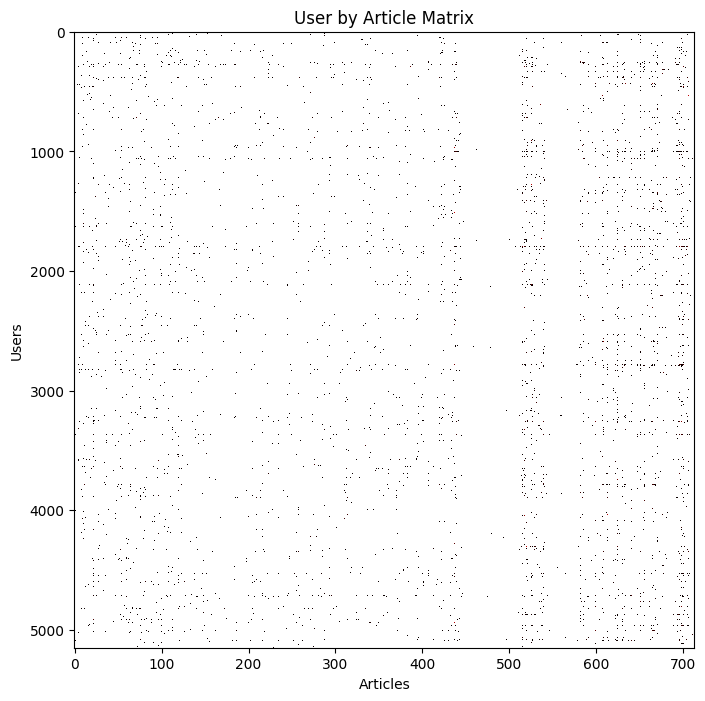

In [80]:
# Display the user by article matrix to get an idea of how dense the matrix is

# Setup the plot
fig, ax = plt.subplots(1,1, figsize=(8, 8))
plt.title('User by Article Matrix')
plt.xlabel('Articles')
plt.ylabel('Users')
# Plot the user by article matrix
ax.imshow(user_by_article, cmap='hot', interpolation='nearest', aspect='auto')

The matrix is sparse. Some articles seem not to be viewed by users at all, because there are widely blank strands in the plot.

In [81]:
# Create a plot of the number of articles read by each user

# Do the caluclation and taking a look at the dataframe
user_article_counts = df.groupby('email')['article_id'].count()
# Sort the values in descending order
user_article_counts = user_article_counts.sort_values(ascending=False)
# Taking a look at the dataframe
user_article_counts.head()


email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
Name: article_id, dtype: int64

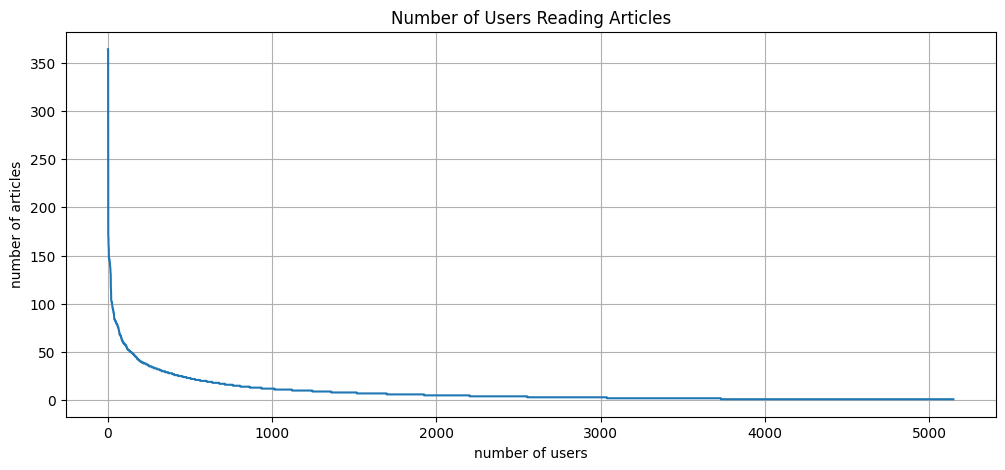

In [82]:
# Plotting the dataframe
fig, ax = plt.subplots(1,1, figsize=(12, 5))
ax.plot(user_article_counts.values)
ax.set_title('Number of Users Reading Articles')
ax.set_xlabel('number of users')
ax.set_ylabel('number of articles')
ax.grid()


Only a small proportion of users reads more than 10 articles.

In [83]:
# Create a plot of the number of times each article was read

# Do the calculation and taking a look at the dataframe
article_read_count = df.groupby('article_id')['email'].count()
# Sort the values in descending order
article_read_count = article_read_count.sort_values(ascending=False)
article_read_count.head()


article_id
1429    937
1330    927
1431    671
1427    643
1364    627
Name: email, dtype: int64

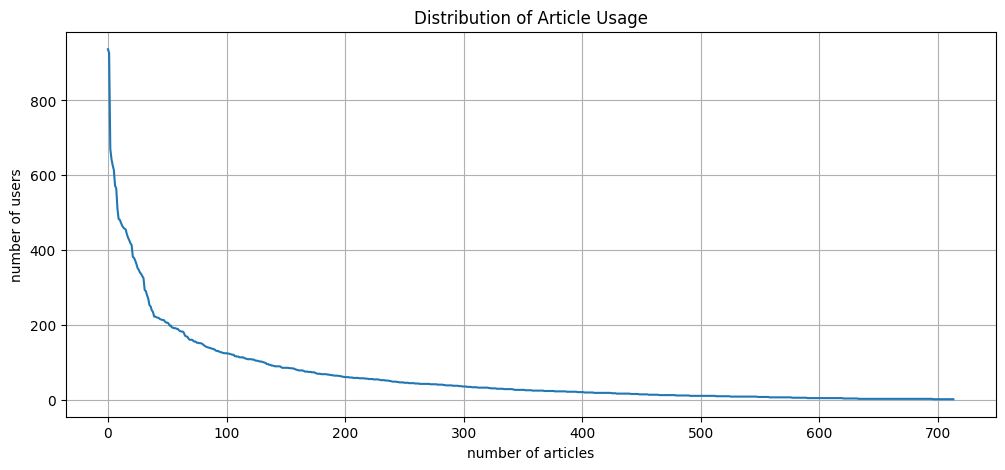

In [84]:
# Plot the dataframe
fig, ax = plt.subplots(1,1, figsize=(12, 5))
ax.plot(article_read_count.values)
plt.xlabel('number of articles')
plt.ylabel('number of users')
plt.title('Distribution of Article Usage')
plt.grid()
plt.show()

Only 100 articles are read more than about 150 times.

In [85]:
# Fill in the median and maximum number of user_article interactions below

median_val =  int(user_article_counts.median())  # 50% of individuals interact with 3 articles or fewer.
print(f'Median user-article counts: {median_val}')
max_views_by_user =  int(user_by_article.sum(axis=1).max()) # The maximum number of user-article interactions by any 1 user is 364.
print(f'Max user-article interaction: {max_views_by_user}')

Median user-article counts: 3
Max user-article interaction: 364


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [86]:
unique_articles =  int((user_by_article.sum(axis=0)>0).sum()) # The number of unique articles that have at least one interaction
print(f'The number of unique articles: {unique_articles}')
total_articles =  int(len(df['article_id'].unique())) # The number of unique articles on the IBM platform
print(f'The number of total articels: {total_articles}')
unique_users =  len(df['email'].unique()) # The number of unique users
print(f'The number of unique users: {unique_users}')
user_article_interactions =  int(user_by_article.sum().sum()) # The number of user-article interactions
print(f'The number of user-article interactions: {user_article_interactions}')

The number of unique articles: 714
The number of total articels: 714
The number of unique users: 5149
The number of user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [87]:
# most_viewed_article_id =  f'{article_read_count.index[0]:.1f}' # The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id =  int(article_read_count.index[0])
max_views =  int(article_read_count.values[0]) # The most viewed article in the dataset was viewed how many times?

In [88]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df=df):
    coded_dict = {
        email: num 
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]

df['user_id'] = email_mapper(df)
del df['email']

# show header
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [89]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [90]:
df.groupby('title')['user_id'].count().sort_values(ascending=False).head(10)

title
use deep learning for image classification                            937
insights from new york car accident reports                           927
visualize car data with brunel                                        671
use xgboost, scikit-learn & ibm watson machine learning apis          643
predicting churn with the spss random tree algorithm                  627
healthcare python streaming application demo                          614
finding optimal locations of new store using decision optimization    572
apache spark lab, part 1: basic concepts                              565
analyze energy consumption in buildings                               512
gosales transactions for logistic regression model                    483
Name: user_id, dtype: int64

In [91]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    # Get the top articles by user_id count, sort in descending order and select top n
    top_articles_series = df.groupby('title')['user_id'].count().sort_values(ascending=False).head(n)
    
    # Convert the series to a list
    top_articles = top_articles_series.index.tolist() # Get the top article titles
    
    return top_articles # Return the top article titles from df

def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    
    # Get the top article ids by user_id count, sort in descending order and select top n
    top_articles_series = df.groupby('article_id')['user_id'].count().sort_values(ascending=False).head(n)
    
    # Convert the series to a list
    top_articles = top_articles_series.index.tolist() # Get the top article titles

    return top_articles # Return the top article ids

In [92]:
print(f'The top ten articles are: {get_top_articles(10)}')
print(f'The top ten article ids are: {get_top_article_ids(10)}')

The top ten articles are: ['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
The top ten article ids are: [1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [93]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [94]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df, fill_value=0):
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    """
    # Fill in the function here
    # Create a user-item matrix with user_id as rows and article_id as columns
    user_item = df.groupby(['user_id', 'article_id'])['article_id'].count().unstack()
    # Fill NaN values with 0
    user_item = user_item.fillna(0)
    # Convert the other values to 1
    user_item[user_item != 0] = 1
    
    return user_item # return the user_item matrix 

# Create the actual matrix with the function
user_item = create_user_item_matrix(df)

In [95]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [96]:
# Lets use the cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [97]:
def find_similar_users(user_id, user_item=user_item, include_similarity=False):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of user ids. If include_similarity is True, returns a list of lists
    where the first element is the user id and the second the similarity.
    
    """
    
    # Compute similarity of each user to the provided user
    idx = user_item.index.get_loc(user_id)
    # Compute similarity of each user to the provided user
    cos_sim = cosine_similarity(user_item, user_item)
    scores = list(enumerate(cos_sim[idx]))

    # Sort by similarity
    # Remove the own user's id
    scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:]
    
    # Create list of just the ids
    sim_users = [i[0] for i in scores]
    
    # Create list of just the similarities
    sims = [i[1] for i in scores]
    most_similar_users = user_item.index[sim_users]
    
    if include_similarity:
        return [[a, b] for a, b in zip(most_similar_users, sims)] # return a list of lists with [[similar_user_id, similarity], ...]
    return most_similar_users # return a list of the users in order from most to least similar
        

In [98]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: Index([3933, 46, 4201, 253, 824, 5034, 5041, 136, 2305, 395], dtype='int64', name='user_id')
The 5 most similar users to user 3933 are: Index([1, 46, 4201, 253, 824], dtype='int64', name='user_id')
The 3 most similar users to user 46 are: Index([4201, 790, 5077], dtype='int64', name='user_id')


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [99]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    """
    # Your code here

    # Look up the article names in the dataframe
    article_names = list(df.loc[df['article_id'].isin(article_ids), 'title'].unique())
    
    return article_names # Return the article names associated with list of article ids

def get_ranked_article_unique_counts(article_ids, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise 
    
    OUTPUT:
    article_counts - (list) a list of tuples with article_id and number of 
                     unique users that have interacted with the article, sorted
                     by the number of unique users in descending order
    
    Description:
    Provides a list of the article_ids and the number of unique users that have
    interacted with the article using the user_item matrix, sorted by the number
    of unique users in descending order
    """
    # Your code here
    # Get the article ids from the user_item matrix
    selected_articles_dataframe = user_item[article_ids]
    # Sort the values in descending order
    selected_articles_series = selected_articles_dataframe.sum(axis=0).sort_values(ascending=False)
    # Convert the series to a list in a list
    ranked_article_unique_counts = [[x, int(y)] for x, y in selected_articles_series.items()]

    return ranked_article_unique_counts


def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    """
    # Your code here
    # Get the article ids from the user_item matrix
    selected_user_articles = user_item[user_item.index == user_id].T
    # Get the article ids from the user_item matrix
    articles_read_by_user = selected_user_articles[selected_user_articles[user_id] == 1]

    # Get article ids as list    
    article_ids = articles_read_by_user.index.tolist()

    # Get the titles to the article ids
    article_names = get_article_names(article_ids=article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    """
    # Your code here
    
    # Inilialize the list of recommendations
    recs = []

    # Get the articles read by the user
    own_user_articles = get_user_articles(user_id=user_id, user_item=user_item)
    # print(own_user_articles[0]) # for debugging purpose

    # Find similar users for the current user
    similar_users = find_similar_users(user_id, include_similarity=False)

    # Loop through the similar users
    i = 0
    while len(recs) < m:
        # print(f"User {i}: {similar_users[i]}") # for debugging purpose
        # Get the articles read by the similar user
        similar_user_articles = get_user_articles(user_id=similar_users[i], user_item=user_item)
        #  Rank the articles
        similar_user_ranked_article_unique_counts = get_ranked_article_unique_counts(similar_user_articles[0], user_item)

        # Count up for next loop run
        i += 1

        # Loop through the ranked articles read by the similar user
        for j in range(len(similar_user_ranked_article_unique_counts)):
            # print(similar_user_ranked_article_unique_counts[0]) # for debugging purpose
            if similar_user_ranked_article_unique_counts[j][0] not in (own_user_articles[0] or recs):
                recs.append(similar_user_ranked_article_unique_counts[j][0])
                if len(recs) >= 10:
                    break
    
    return recs # return your recommendations for this user_id    

In [100]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['the nurse assignment problem',
 'predicting churn with the spss random tree algorithm',
 'analyze energy consumption in buildings',
 'analyze open data sets with pandas dataframes',
 'access mysql with r',
 'use sql with data in hadoop python',
 'pixieapp for outlier detection',
 'model bike sharing data with spss',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'the pandas data analysis library']

In [101]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == [1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [102]:
def get_top_sorted_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int)
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe, i.e. Descending order
     
    """
    # Your code here
    # Hint: find similar users, but include their similarity, from there we can find the number of interactions for each neighbor

    # Find similar users for the current user and get the similarity scores
    similar_users = find_similar_users(user_id, include_similarity=True)
    # Create a dataframe from the similar users
    neighbors_df = pd.DataFrame(similar_users, columns=['user_id', 'similarity'])
    # Add the number_interactions column to the dataframe
    neighbors_df['num_interactions'] = neighbors_df['user_id'].apply(lambda x: user_item[user_item.index == x].sum(axis=1).values[0])
    # Sort it
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=[False, False])
    #neighbors_df.head(20) # for debugging purpose
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    """
    # Your code here

    # Initialize the list of recommendations
    recs = []
    # Get the articles read by the current user
    own_user_articles = get_user_articles(user_id=user_id, user_item=user_item)
    # print(own_user_articles[0]) # for debugging purpose

    # Find similar sorted users for the current user
    similar_users = get_top_sorted_users(user_id)

    # Loop through the similar users
    i = 0
    while len(recs) < m:
        similar_user = int(similar_users.iloc[i,:].user_id)
        # print(f"User {i}: {similar_user}") # for debugging purpose
        similar_user_articles = get_user_articles(user_id=similar_user, user_item=user_item)
        similar_user_ranked_article_unique_counts = get_ranked_article_unique_counts(similar_user_articles[0], user_item)

        # Count up for next loop run
        i += 1

        # Loop through the ranked articles read by the similar user
        for j in range(len(similar_user_ranked_article_unique_counts)):
            # print(similar_user_ranked_article_unique_counts[0])
            if similar_user_ranked_article_unique_counts[j][0] not in (own_user_articles[0] or recs):
                recs.append(similar_user_ranked_article_unique_counts[j][0])
                if len(recs) >= 10:
                    break
    
    return recs, get_article_names(recs) # return your recommendations for this user_id

In [103]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1185, 1162, 1165, 1293, 1185, 1165, 1293, 254, 1271, 1328]

The top 10 recommendations for user 20 are the following article names:
['classify tumors with machine learning', 'analyze energy consumption in buildings', 'income (2015): united states demographic measures', 'analyze precipitation data', 'finding optimal locations of new store using decision optimization', 'customer demographics and sales', 'apple, ibm add machine learning to partnership with watson-core ml coupling']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [104]:
print(get_top_sorted_users(1, user_item=user_item).head(n=1))
print(get_top_sorted_users(2, user_item=user_item).head(n=10))
print(get_top_sorted_users(131, user_item=user_item).head(n=10))

   user_id  similarity  num_interactions
0     3933    0.986013              35.0
    user_id  similarity  num_interactions
0      5083    0.730297               5.0
1      1552    0.577350               2.0
2      1890    0.577350               2.0
3      1372    0.471405               3.0
4      2941    0.433013               8.0
37     3586    0.408248               4.0
5       331    0.408248               1.0
6       348    0.408248               1.0
7       378    0.408248               1.0
8       496    0.408248               1.0
   user_id  similarity  num_interactions
0     3870    0.986667              75.0
1      203    0.388909              96.0
2     4459    0.388909              96.0
3     3782    0.387585             135.0
4       40    0.384308              52.0
5     4932    0.384308              52.0
6       23    0.377647             135.0
7      242    0.375823              59.0
8     3910    0.372678              60.0
9      383    0.367423              32.0


In [105]:
### Tests with a dictionary of results
user1_most_sim = 3933 # Find the user that is most similar to user 1 
user2_6th_sim =  3586 # Find the 6th most similar user to user 2
user131_10th_sim = 383 # Find the 10th most similar user to user 131

In [106]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Answer:

This problem with new users without a record is called a "cold start problem". I would first use the function "get_top_articles" to determine top rated articles. Then determine on which article the user clicks and with the then first user-item interactions refine the recommendations with user-user based collaborative filtering. If a new user signs up and gives additional information about his age or residency country and this information is also available for other users in the database, a better initial recommendation through customer clustering and segmentations could be possible.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [107]:
# What would your recommendations be for this new user 0?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here

print(f'Recommendation to completely new user: {new_user_recs}')

Recommendation to completely new user: [1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [108]:
assert set(new_user_recs) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Use the function bodies below to create a content based recommender function `make_content_recs`. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [37]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [109]:
# Imports
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [110]:
# unique articles
df_unique_articles = df[['article_id', 'title']].drop_duplicates()
df_unique_articles

,article_id,title
0,1430,"using pixiedust for fast, flexible, and easier..."
1,1314,healthcare python streaming application demo
2,1429,use deep learning for image classification
3,1338,ml optimization using cognitive assistant
4,1276,deploy your python model as a restful api
...,...,...
24278,1156,airbnb data for analytics: washington d.c. cal...
24616,555,build a naive-bayes model with wml & dsx
24726,708,load and analyze public data sets in dsx
24737,575,the new builders ep. 13: all the data that’s f...


In [111]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)
print("Running TF-IDF")
X_tfidf =  vectorizer.fit_transform(df_unique_articles['title']) # Fit the vectorizer to the article titles

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf) # Fit the LSA model to the vectorized article titles
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
n_samples: 714, n_features: 125
Explained variance of the SVD step: 76.0%


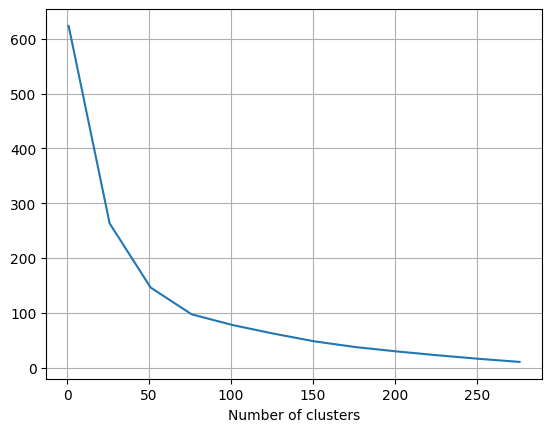

In [113]:
# Let's map the inertia for different number of clusters to find the optimal number of clusters
# We'll plot it to see the elbow
inertia = []
clusters = 300
step = 25
max_iter = 50
n_init = 5
random_state = 42
for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    # inertia is the sum of squared distances to the closest cluster center
    inertia.append(kmeans.inertia_)
plt.plot(range(1, clusters, step), inertia)
plt.xlabel('Number of clusters')
plt.grid()

There appears to be an elbow about 50, so we'll use 50 clusters.

In [114]:
n_clusters = 50 # Number of clusters
kmeans = KMeans(
    n_clusters=n_clusters,
    max_iter=max_iter,
    n_init=n_init,
    random_state=random_state,
).fit(X_lsa)

In [115]:
# Check the dimensions of the labels of the trained kmeans model
len(kmeans.labels_)

714

In [116]:
# create a new column `title_cluster` and assign it the kmeans cluster labels
# Map the labels from df_unique_articles (unique articles) to df
article_cluster_map = dict(zip(df_unique_articles['article_id'], kmeans.labels_))  # Map unique article_id to cluster label
df['title_cluster'] = df['article_id'].map(article_cluster_map)  # apply map to create title clusters

# Only cast to int where not null, or keep as float (int casting is not necessary for clustering)
df.head()

,Unnamed: 0,article_id,title,user_id,title_cluster
0,0,1430,"using pixiedust for fast, flexible, and easier...",1,19
1,1,1314,healthcare python streaming application demo,2,6
2,2,1429,use deep learning for image classification,3,35
3,3,1338,ml optimization using cognitive assistant,4,19
4,4,1276,deploy your python model as a restful api,5,15


In [117]:
# Check the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     45993 non-null  int64 
 1   article_id     45993 non-null  int64 
 2   title          45993 non-null  object
 3   user_id        45993 non-null  int64 
 4   title_cluster  45993 non-null  int32 
dtypes: int32(1), int64(3), object(1)
memory usage: 1.6+ MB


In [118]:
# Let's check the number of articles in each cluster
np.array(np.unique(kmeans.labels_, return_counts=True)).T

array([[ 0, 19],
       [ 1,  3],
       [ 2, 70],
       [ 3,  8],
       [ 4, 31],
       [ 5, 35],
       [ 6,  9],
       [ 7, 19],
       [ 8,  6],
       [ 9, 13],
       [10, 23],
       [11, 27],
       [12, 20],
       [13, 25],
       [14, 35],
       [15, 19],
       [16, 20],
       [17,  8],
       [18,  8],
       [19, 18],
       [20, 16],
       [21, 18],
       [22,  9],
       [23, 10],
       [24, 12],
       [25,  7],
       [26,  4],
       [27, 10],
       [28, 17],
       [29, 15],
       [30,  8],
       [31,  9],
       [32,  8],
       [33, 10],
       [34,  9],
       [35, 17],
       [36,  9],
       [37,  7],
       [38, 10],
       [39, 10],
       [40, 10],
       [41,  5],
       [42, 12],
       [43,  7],
       [44,  5],
       [45,  3],
       [46,  8],
       [47, 11],
       [48, 12],
       [49, 10]])

In [119]:
def get_similar_articles(article_id, df=df):
    """
    INPUT:
    article_id - (int) an article id 
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids that are in the same title cluster
    """
    # Your code here
    # Get the title cluster for the input article_id
    title_cluster = df.loc[df['article_id'] == article_id, 'title_cluster'].values[0]
    # Get the article ids in the same title cluster
    articles_in_cluster = df.loc[df['title_cluster'] == title_cluster, 'article_id'].unique().tolist()
    
    # Remove the input article_id from the list
    articles_in_cluster.remove(article_id)
    
    return articles_in_cluster

In [120]:
# Test the function
get_similar_articles(25)

[586,
 693,
 508,
 132,
 766,
 101,
 1025,
 547,
 975,
 878,
 986,
 115,
 428,
 188,
 48,
 92,
 157,
 183]

In [121]:
def make_content_recs(article_id, n, df=df):
    """
    INPUT:
    article_id - (int) an article id
    n - (int) the number of recommendations you want similar to the article id
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    n_ranked_similar_articles - (list) a list of article ids that are in the same title cluster ranked
                                by popularity
    n_ranked_article_names - (list) a list of article names associated with the list of article ids
    
    Description:
    Returns a list of the n most ranked similar articles to a given article_id based on the title
    cluster in df. Rank similar articles using the function get_ranked_article_unique_counts.
    """
    # Your code here
    # Get the similar articles
    recommended_articles = get_similar_articles(article_id)
    # Rank the articles
    ranked_articles = get_ranked_article_unique_counts(recommended_articles)
    # Limit the number of articles to n
    n_ranked_similar_articles = ranked_articles[:n]
    # Only extract the article ids
    n_ranked_similar_articles = [x[0] for x in n_ranked_similar_articles]
    # Get the article titles
    n_ranked_article_names = get_article_names(n_ranked_similar_articles)
    
    return n_ranked_similar_articles, n_ranked_article_names
        

In [122]:
# Test out your content recommendations given artice_id 25
rec_article_ids, rec_article_titles = make_content_recs(25, 10)
print(f'Article ids: {rec_article_ids}')
print(f'Article titles: {rec_article_titles}')

Article ids: [1025, 101, 975, 766, 508, 547, 132, 878, 92, 693]
Article titles: ['better together: spss and data science experience', 'data science in the cloud', 'collecting data science cheat sheets', 'making data science a team sport', 'how to choose a project to practice data science', 'data tidying in data science experience', 'trust in data science', 'the data science process', '10 data science podcasts you need to be listening to right now', '9 mistakes to avoid when starting your career in data science']


In [123]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

Content based recommendation systems try to rank by the content of the individual items. I this project ranks to an article are generated with TF-IDF NLP algorithm, which allows to find similar articles by analysing their titles. The similar the articles to the given article, the higher the score.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [52]:
# quick look at the matrix
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [124]:
# Imports
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

Text(0.5, 1.0, 'Metrics vs. Number of Latent Features')

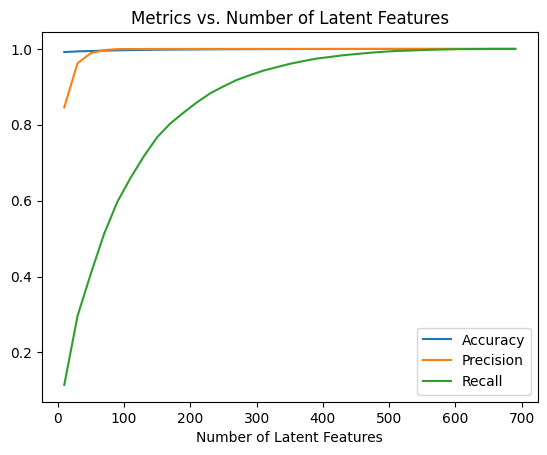

In [ ]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])
    
    
plt.plot(num_latent_feats, metric_scores, label=['Accuracy', 'Precision', 'Recall'])
plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features')
plt.grid()

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

A number of 200 latent features looks like a good trade-off between effort and provided results, although no clear elbow is visible. If the recommendation system only offers results, which best fit to the previous results, the customer is not provided with a divers and maybe refreshing recommendations.

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [126]:
def get_svd_similar_article_ids(article_id, vt, user_item=user_item, include_similarity=False):
    """
    INPUT:
    article_id - (int) an article id
    vt - (numpy array) vt matrix from SVD
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids similar using SVD factorization
    """
    # Find the index of the article_id
    article_idx = user_item.columns.get_loc(article_id)
    # Find the cosine similarity of all articles
    # Hint: vt should be transposed before passing to cosine_similarity to get a 714 x 714 matrix 
    cos_sim = cosine_similarity(vt.T, vt.T)
    # Get similarities only for the cos_sim of the article_idx
    scores = list(cos_sim[article_idx])
    
    # Sort and return the articles, don't include the own article
    id_scores_df = pd.DataFrame(zip(user_item.columns, scores), columns=['article_id', 'similarity'])
    # Drop own article
    id_scores_df = id_scores_df.drop(article_idx)
    # Sort
    id_scores_df = id_scores_df.sort_values(by='similarity', ascending=False)
    # Convert to list
    most_similar_items = id_scores_df['article_id'].tolist()
    
    if include_similarity:
        return id_scores_df[['article_id', 'similarity']].values.tolist() # return a list of lists with [[similar_article_id, similarity], ...]
    return most_similar_items

In [127]:
# Create a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]
vt_new

array([[ 0.00221822,  0.02604036,  0.00246327, ...,  0.00050441,
         0.00492688,  0.00404343],
       [-0.00207737,  0.0281658 , -0.00051368, ..., -0.00262161,
        -0.01325774, -0.01327298],
       [ 0.00043211, -0.0135172 , -0.00300468, ..., -0.00157638,
        -0.01481189, -0.00798957],
       ...,
       [ 0.00052298,  0.03114128,  0.0412575 , ..., -0.00481181,
         0.02392748,  0.01149674],
       [ 0.01517699,  0.03271468, -0.00647556, ..., -0.00124832,
        -0.0036916 , -0.02407027],
       [ 0.01029133,  0.00532077, -0.01000918, ..., -0.00263044,
         0.04288296,  0.02769194]], shape=(200, 714))

In [57]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

Current article: analyze ny restaurant data using spark in dsx


In [58]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

[1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132]

In [59]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

['use spark r to load and analyze data',
 'collecting data science cheat sheets',
 '10 powerful features on watson data platform, no coding necessary',
 'notebooks: a power tool for data scientists',
 'country statistics: crude oil - proved reserves',
 'country statistics: crude oil - exports',
 'top analytics tools in 2016',
 'advancements in the spark community',
 'airbnb data for analytics: paris calendar',
 'airbnb data for analytics: athens reviews']

In [60]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

**Your response here.**

In [ ]:
# Convert the notebook to HTML

from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb', '--to', 'html'])

[NbConvertApp] Converting notebook Recommendations_with_IBM.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 647756 bytes to Recommendations_with_IBM.html


0